In [106]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [107]:
# Load dataset
df = pd.read_csv('Stress_Level_Prediction_Dataset_Updated.csv')

In [108]:
from scipy.stats import zscore
def cap_floor_outliers(df, columns, threshold=3):
    for col in columns:
        # Calculate Z-scores
        z_scores = zscore(df[col])
        
        # Cap and floor based on the threshold
        df[col] = np.where(z_scores > threshold, 
                           df[col].mean() + threshold * df[col].std(),  # Cap high outliers
                           np.where(z_scores < -threshold, 
                                    df[col].mean() - threshold * df[col].std(),  # Floor low outliers
                                    df[col]))  # Keep non-outliers as is
    return df

# Apply to the specified columns
columns_to_process = ['Heart_Rate', 'Diastolic_BP', 'Systolic_BP', 'Pulse_Rate']
threshold = 3  # Define the Z-score threshold
df = cap_floor_outliers(df, columns_to_process, threshold)

                         Age  Pulse_Rate  Systolic_BP  Diastolic_BP  \
Age                 1.000000   -0.004018     0.000194      0.008918   
Pulse_Rate         -0.004018    1.000000    -0.007418      0.024380   
Systolic_BP         0.000194   -0.007418     1.000000      0.028098   
Diastolic_BP        0.008918    0.024380     0.028098      1.000000   
Heart_Rate         -0.002516    0.939838    -0.003673      0.024921   
Financial_Stress   -0.005799    0.007048    -0.003366     -0.005438   
Work_Hours          0.015287   -0.010870     0.007128     -0.004180   
Sleep_Hours         0.008385   -0.016478    -0.009329      0.006983   
Illness_Severity   -0.013936   -0.002041     0.000383     -0.011140   
Social_Interaction -0.013237   -0.011603    -0.007534     -0.004229   
Exercise_Hours      0.018592    0.013824     0.001625      0.002731   
Diet_Quality        0.012574   -0.009383     0.017649      0.000212   
Life_Satisfaction   0.002112   -0.004373    -0.000594     -0.004021   
Substa

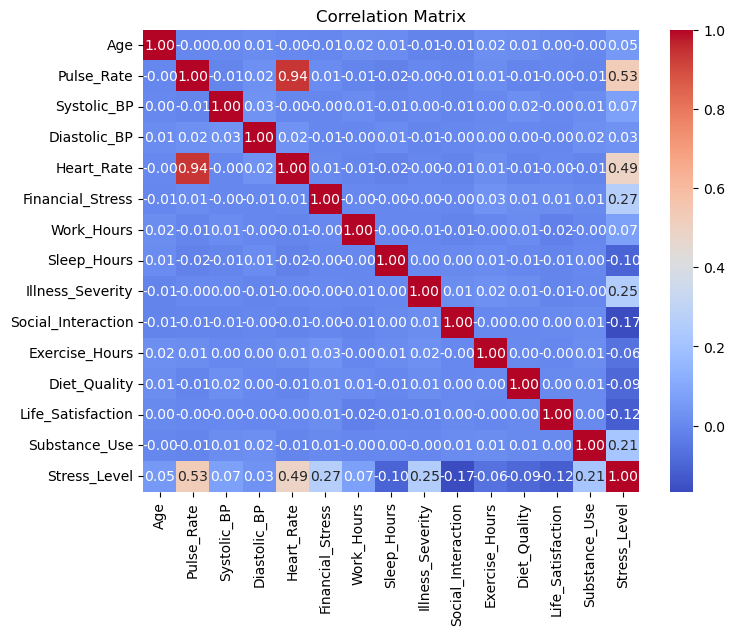

In [109]:
correlation_matrix = df.corr(method='pearson')  # Use 'spearman' or 'kendall' for non-linear relationships
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [110]:
threshold = 0.85
upper_triangle = correlation_matrix.where(
    ~np.tril(np.ones(correlation_matrix.shape, dtype=bool))
)

# Find features to drop
features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
df = df.drop(columns=features_to_drop)

print("Dropped features:", features_to_drop)


Dropped features: ['Heart_Rate']


In [111]:
df


,Age,Pulse_Rate,Systolic_BP,Diastolic_BP,Financial_Stress,Work_Hours,Sleep_Hours,Illness_Severity,Social_Interaction,Exercise_Hours,Diet_Quality,Life_Satisfaction,Substance_Use,Stress_Level
0,22,80.0,109.8,83.5,2,44,10.0,9,8,5.5,8,8,5,8.5
1,57,73.6,115.4,82.8,5,41,7.4,5,5,1.5,2,1,6,3.4
2,22,81.5,111.0,70.6,3,70,8.7,4,9,3.0,3,5,1,0.0
3,63,90.2,121.7,85.8,3,71,9.3,4,8,0.0,4,1,10,12.4
4,55,72.7,138.0,65.1,4,71,6.2,7,3,5.7,7,8,0,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,43,88.0,125.8,74.2,4,50,8.9,5,6,5.0,8,7,6,9.3
9996,58,55.0,140.7,94.4,6,34,6.8,7,2,4.2,5,9,3,0.0
9997,61,67.9,125.7,75.0,5,52,4.1,0,8,2.4,3,10,7,2.9
9998,35,80.0,145.7,61.1,3,34,7.0,1,10,5.4,8,2,2,0.0


In [112]:
X = df.drop(columns=["Stress_Level"])  # Input features
y = df["Stress_Level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [138]:
model = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),  # First hidden layer
    Dense(8, activation='relu'),                             # Second hidden layer
    Dense(4, activation='relu'),
    Dense(1, activation='linear')                             # Output layer for regression
])

C:\Users\BIT\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [140]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
Ann_model = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict on new data
y_pred = model.predict(X_test)

Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.7801 - mae: 3.8154 - val_loss: 10.7882 - val_mae: 2.6022
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.1466 - mae: 2.5765 - val_loss: 9.0099 - val_mae: 2.3576
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4953 - mae: 2.3257 - val_loss: 8.3723 - val_mae: 2.2416
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9474 - mae: 2.2511 - val_loss: 7.7920 - val_mae: 2.2638
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7240 - mae: 2.2217 - val_loss: 7.2945 - val_mae: 2.1477
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5249 - mae: 2.1946 - val_loss: 7.5207 - val_mae: 2.1423
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5976 - mae: 2.1879 - val_loss: 7.2223 - val_mae: 2.1246
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2078 - mae: 2.1400 - val_loss: 7.1786 - val_mae: 2.1202
Epoch 9/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [142]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

R² Score: 0.5335793477433952


In [156]:
import numpy as np

# Define the number of features (based on your dataset)
num_features = X_test.shape[1]

# Take input from the user
user_input = input(f"Enter {num_features} values separated by commas: ")

# Process the input
user_data = np.array([float(x) for x in user_input.split(',')]).reshape(1, -1)

# Check if the input matches the expected feature size
if user_data.shape[1] != num_features:
    print(f"Error: Expected {num_features} features, but got {user_data.shape[1]}.")
else:
    # Make prediction
    prediction = model.predict(user_data)
    if prediction > 20 :
            prediction = 19.2
    print(f"Prediction: {prediction}")


Enter 13 values separated by commas:  35,76.0,120.0,80.0,3,45,7.5,5,7,4.0,6,7,2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: [[1.5655429]]
